Name: Aaron Bastian

## Data
#### Source: 
[Kaggle Link](https://www.kaggle.com/competitions/online-purchase-prediction/data?select=shop_train.csv)

#### Description:
Each row represents a visit to an online store.  The following are the column/feature descriptions:

`admin_pages`, `info_pages`, `product_pages` - number of pages in different categories visited by the user  
`admin_seconds`, `info_seconds`, `product_seconds` - time spent by the user on different page categories  
`bounce_rate`, `bounce_rate`, `quit_rate` - numbers from Google Analytics  
`is_holiday` - the proximity of important days for retail (such as the New Year)  
`month` - month (categorical variable)  
`operating_system_id`, `browser_id`, `region_id`, `traffic_type_id` are also categorical variables, although they are written as numbers  
`is_new_visitor`, `is_weekend` - binary signs  
`has_purchase` - binary attribute, target variable. It is he who needs to learn to predict.  

In [1]:
import numpy as np
import pandas as pd

In [2]:
train_df = pd.read_csv("Data/shop_train.csv")

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6165 entries, 0 to 6164
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   admin_pages          6165 non-null   int64  
 1   admin_seconds        6165 non-null   float64
 2   info_pages           6165 non-null   int64  
 3   info_seconds         6165 non-null   float64
 4   product_pages        6165 non-null   int64  
 5   product_seconds      6165 non-null   float64
 6   bounce_rate          6165 non-null   float64
 7   quit_rate            6165 non-null   float64
 8   page_value           6165 non-null   float64
 9   is_holiday           6165 non-null   float64
 10  month                6165 non-null   object 
 11  operating_system_id  6165 non-null   int64  
 12  browser_id           6165 non-null   int64  
 13  region_id            6165 non-null   int64  
 14  traffic_type_id      6165 non-null   int64  
 15  is_new_visitor       6165 non-null   i

In [3]:
train_df.describe()

,admin_pages,admin_seconds,info_pages,info_seconds,product_pages,product_seconds,bounce_rate,quit_rate,page_value,is_holiday,operating_system_id,browser_id,region_id,traffic_type_id,is_new_visitor,is_weekend,has_purchase
count,6165.000000,6165.000000,6165.000000,6165.000000,6165.000000,6165.000000,6165.000000,6165.000000,6165.000000,6165.000000,6165.000000,6165.000000,6165.000000,6165.000000,6165.000000,6165.000000,6165.000000
mean,2.335280,80.852833,0.507867,33.280329,32.408273,1208.587423,0.021689,0.042682,5.937796,0.060697,2.122952,2.392863,3.086456,4.074615,0.133658,0.230170,0.154745
std,3.356446,175.414952,1.272868,134.065358,45.243435,1810.567652,0.047605,0.047973,18.211659,0.198423,0.906463,1.787116,2.377666,4.054737,0.340312,0.420976,0.361690
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,191.000000,0.000000,0.014196,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000,0.000000,0.000000,0.000000
50%,1.000000,7.600000,0.000000,0.000000,18.000000,608.883333,0.003188,0.025492,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000
75%,4.000000,93.300000,0.000000,0.000000,38.000000,1503.250000,0.016667,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000,0.000000,0.000000,0.000000
max,27.000000,2720.500000,16.000000,2256.916667,686.000000,24844.156200,0.200000,0.200000,360.953384,1.000000,8.000000,13.000000,9.000000,20.000000,1.000000,1.000000,1.000000


In [4]:
train_df.head()

,admin_pages,admin_seconds,info_pages,info_seconds,product_pages,product_seconds,bounce_rate,quit_rate,page_value,is_holiday,month,operating_system_id,browser_id,region_id,traffic_type_id,is_new_visitor,is_weekend,has_purchase
0,0,0.000000,0,0.0,8,335.000000,0.025000,0.050000,63.891,0.0,May,3,2,4,1,0,0,1
1,2,54.500000,4,29.5,11,1055.750000,0.000000,0.026667,0.000,0.0,Dec,2,2,1,2,1,0,0
2,4,72.000000,0,0.0,4,46.500000,0.040000,0.060000,0.000,0.0,Nov,3,2,2,3,0,0,0
3,3,23.166667,0,0.0,12,122.225000,0.000000,0.014286,0.000,0.0,Dec,2,2,9,2,1,1,0
4,12,356.125000,0,0.0,44,2187.338725,0.005102,0.029042,0.000,0.0,Dec,1,1,8,1,0,0,0


Our target variable will be `has_purchase`.  This is of course heavily skewed as most users will not purchase anything, and in this case it appears that about 15.5% of users made purchases (we can use the mean because it is a binary variable).  Thus, our target accuracy will be >84.5%, which is what a model could achieve by simply predicting 0 (no purchase) for eveything.  I will also be utilizing Ensemble methods for my classifier, as they are more resistant to skew and overfitting by wieghting their internal models.  In particular, I will use the `XGBClassifier` class from `xgboost`.

In [5]:
from sklearn.model_selection import train_test_split

X = train_df.drop("has_purchase", axis=1)
y = train_df.has_purchase

X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, random_state=69)

y_train.value_counts(normalize=True), y_valid.value_counts(normalize=True)

(0    0.845339
 1    0.154661
 Name: has_purchase, dtype: float64,
 0    0.845006
 1    0.154994
 Name: has_purchase, dtype: float64)

In [6]:
from sklearn.preprocessing import FunctionTransformer


month_dict = {"jan": 1, "feb": 2, "mar": 3, "apr": 4, "may": 5, "jun": 6,"jul": 7, "aug": 8, "sep": 9, "oct": 10, "nov": 11, "dec": 12}


def month_to_int(_X):
    _X = _X.copy()
    _X.month = _X.month.apply(str.lower).map(month_dict)
    return _X

month_transformer = FunctionTransformer(month_to_int)

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

steps = [
    ("month_trans", month_transformer),
    ("scaler", StandardScaler()),
    ("xgboost", XGBClassifier())
]

pipe = Pipeline(steps)

In [8]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('month_trans',
                 FunctionTransformer(func=<function month_to_int at 0x133cfbe20>)),
                ('scaler', StandardScaler()),
                ('xgboost',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamm...e,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

Training Acc:  0.9963227341553104
Training F1:  0.9879688605803255
Training AUC:  0.9881118881118881

Validation Acc:  0.8955901426718548
Validation F1:  0.6264501160092807
Validation AUC:  0.7605541765542665


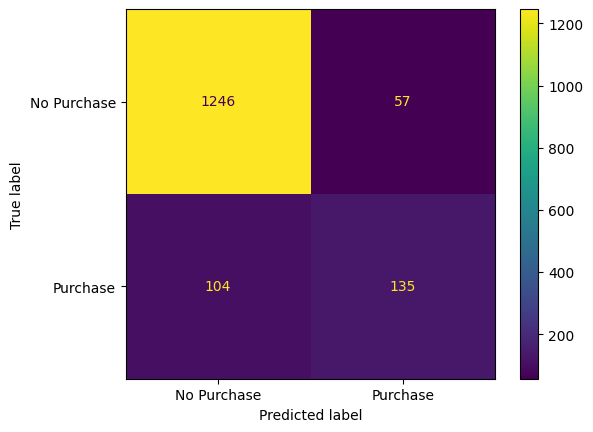

In [9]:
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt

def analyze_model(model) -> None:

    train_preds = model.predict(X_train)
    valid_preds = model.predict(X_valid)

    print("Training Acc: ", accuracy_score(y_train, train_preds))
    print("Training F1: ", f1_score(y_train, train_preds))
    print("Training AUC: ", roc_auc_score(y_train, train_preds))
    print()
    print("Validation Acc: ", accuracy_score(y_valid, valid_preds))
    print("Validation F1: ", f1_score(y_valid, valid_preds))
    print("Validation AUC: ", roc_auc_score(y_valid, valid_preds))

    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_valid, valid_preds, labels=model.classes_), display_labels=["No Purchase", "Purchase"])
    disp.plot()
    plt.show()

analyze_model(pipe)


Not bad.  We are already outperforming our benchmark of 84.5%, but we can do better.  It appears that we are overfitting our data, as we have a near perfect accuracy on out training data and signifficantly lower accuracy on our Validation data (11%).  I will tune the pipeline/model hyperparameters to do this, using a grid search cross validation as the dataset is not too large and there are only three hyperparameters I would like to tune.  
1 and 2: `n_estimators` (default is 100) and `max_depth` (default is 6) | To reduce overfitting  
3: `scale_pos_weight` (default 1) | to balance the weight of the positive class (minority class)  

[docs](https://xgboost.readthedocs.io/en/stable/parameter.html)

In [10]:
from sklearn.model_selection import GridSearchCV

pipe_2 = Pipeline([
    ("month_transformer", month_transformer),
    ("scaler", StandardScaler()),
    ("xgb", XGBClassifier())
])

param_grid = {
    "xgb__max_depth": [2, 3, 5, 7],
    "xgb__n_estimators" : [50, 75, 100],
    "xgb__scale_pos_weight" : [1, 3, 5]
}

grid_search = GridSearchCV(pipe_2, param_grid, cv=5, scoring="roc_auc")
grid_search.fit(X_train, y_train)

grid_search.best_params_

{'xgb__max_depth': 2, 'xgb__n_estimators': 50, 'xgb__scale_pos_weight': 1}

The Grid search revealed that we should decrease our `max_depth` to 2 and our `n_estimators` to 50.  This makes sense as setting both of these parameters too high can lead to high variance and overfitting.

Training Acc:  0.9171533636166991
Training F1:  0.7037896365042536
Training AUC:  0.8024448683353493

Validation Acc:  0.8988326848249028
Validation F1:  0.6372093023255814
Validation AUC:  0.7658894665352246


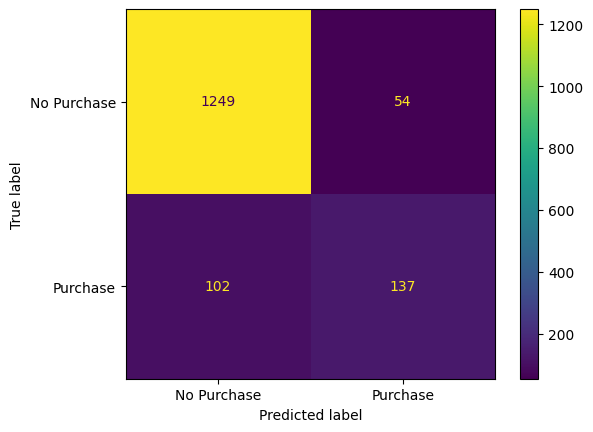

In [11]:
pipe_2 = Pipeline([
    ("month_transformer", month_transformer),
    ("scaler", StandardScaler()),
    ("xgb", XGBClassifier())
])

pipe_2.set_params(**grid_search.best_params_)   # unpacks the dict object into an array of params

pipe_2.fit(X_train, y_train)

analyze_model(pipe_2)

A Validation accuracy of 89.3% which is a 1.2% increase from our baseline model.

In [12]:
from sklearn.metrics import roc_auc_score

final_X = pd.read_csv("Data/shop_test.csv")

test_preds = pipe_2.predict_proba(final_X)[:,1]

In [13]:
sub = pd.DataFrame(test_preds, columns=["prediction"])
sub["id"] = sub.index
sub

,prediction,id
0,0.117609,0
1,0.006153,1
2,0.006784,2
3,0.028695,3
4,0.008010,4
...,...,...
6160,0.006880,6160
6161,0.027121,6161
6162,0.049368,6162
6163,0.091560,6163


In [14]:
sub.to_csv("submission.csv", index=False)

The submissions for the Kaggle competition required the predicitons to be in the form of probabilities so they could calculate the ROC as the evaluation metric.  I recieved a final score of 93.45.

In [15]:
from lightgbm import LGBMClassifier

pipe_3 = Pipeline([
    ("month_transformer", month_transformer),
    ("scaler", StandardScaler()),
    ("lgb", LGBMClassifier())
])

param_grid = {
    "lgb__max_depth": [2, 3, 5, 6],
    "lgb__n_estimators" : [50, 75, 100],
    "lgb__scale_pos_weight" : [1, 3, 5]
}

grid_search = GridSearchCV(pipe_3, param_grid, cv=5, scoring="roc_auc")
grid_search.fit(X_train, y_train)

grid_search.best_params_

{'lgb__max_depth': 3, 'lgb__n_estimators': 50, 'lgb__scale_pos_weight': 3}

Training Acc:  0.8881678563703223
Training F1:  0.6887417218543046
Training AUC:  0.8521494370522007

Validation Acc:  0.8845654993514915
Validation F1:  0.682142857142857
Validation AUC:  0.8496967089144137


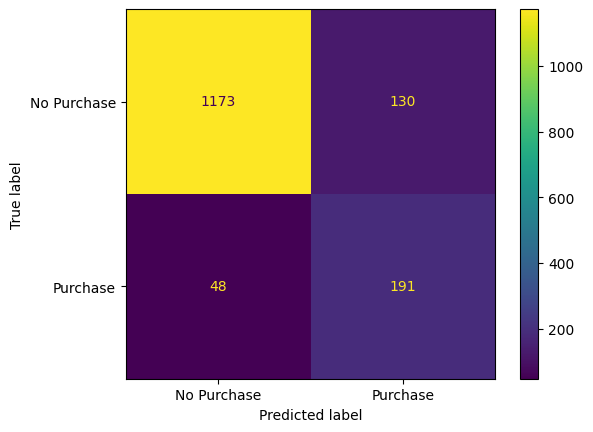

In [16]:
pipe_3 = Pipeline([
    ("month_transformer", month_transformer),
    ("scaler", StandardScaler()),
    ("lgb", LGBMClassifier())
])

pipe_3.set_params(**grid_search.best_params_)

pipe_3.fit(X_train, y_train)

analyze_model(pipe_3)

In [17]:
test_preds = pipe_3.predict_proba(final_X)[:,1]

sub = pd.DataFrame(test_preds, columns=["prediction"])
sub["id"] = sub.index
sub.to_csv("lgbm_submission.csv", index=False)

Though the LGBM model had slightly lower accuracy, it had a significantly higher F1-Score and AUC-ROC, and much lower Type 1 and 2 Errors.  Upon submitting these predictions to Kaggle, I recieved a final score of 93.76.

Targeted Marketing: The company could use the predictions to target their marketing efforts to users who are most likely to buy a product. For example, they could send personalized email campaigns or display targeted ads to these users.

Dynamic Pricing: The company could use the predictions to adjust the prices of products based on a user's likelihood to purchase. For example, they could offer discounts or promotions to users who are less likely to buy a product, or charge more for users who are more likely to buy.

Churn Prediction: The company could use the predictions to identify users who are at risk of not buying again and take actions to retain them. For example, they could send personalized emails with special offers or discounts to users who are at risk of not buying.

Optimization: The company could use the predictions to optimize their website layout, design, and user experience to increase the likelihood of users buying products.